In [21]:
#import dependencies
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [22]:
#get stock quote
df = pdr.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2022-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.591938
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.659608
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.800156
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.933965
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.913450
...,...,...,...,...,...,...
2021-12-27,180.419998,177.070007,177.089996,180.330002,74919600.0,180.330002
2021-12-28,181.330002,178.529999,180.160004,179.289993,79144300.0,179.289993
2021-12-29,180.630005,178.139999,179.330002,179.380005,62348900.0,179.380005


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-03 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2517 non-null   float64
 1   Low        2517 non-null   float64
 2   Open       2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Volume     2517 non-null   float64
 5   Adj Close  2517 non-null   float64
dtypes: float64(6)
memory usage: 137.6 KB


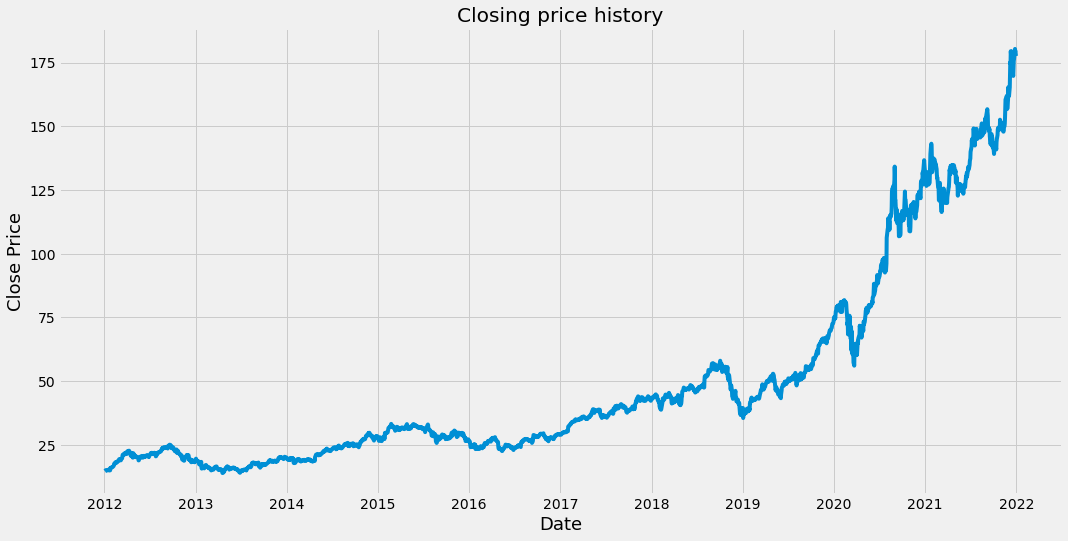

In [24]:
#visualize closing data
plt.figure(figsize=(16,8))
plt.title('Closing price history')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [25]:
#create new dataframe with only close price
data = df.filter(['Close'])
#np array
dataset = data.values
training_len = math.ceil(len(dataset) * .8)
training_len

2014

In [26]:
#scale the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00444329],
       [0.00491767],
       [0.00590292],
       ...,
       [0.99429028],
       [0.98719814],
       [0.98341175]])

In [27]:
#create training dataset
train_data = scaled_data[:training_len,:]
x_train = []
y_train = []

for i in range(60,training_len):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1954, 60, 1)

In [28]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

Metal device set to: Apple M1


2022-01-08 14:28:58.208656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-08 14:28:58.209035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
#compile model
model.compile(optimizer='adam',loss='mean_squared_error')

In [31]:
#train model
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

2022-01-08 14:31:40.829432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-08 14:31:40.829879: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-08 14:31:48.777482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-08 14:31:48.863886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-08 14:31:49.418317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-08 14:31:50.540303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-08 14:31:51.872031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

1954/1954 [==============================] - 93s 42ms/step - loss: 3.3664e-04


In [38]:
#create testing data set
#create new array containing scaled values from index 
test_data = scaled_data[training_len-60:,:]
#create x,y test

x_test = []
y_test = dataset[training_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)


In [39]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [40]:
#get models predicted price
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [41]:
#evaluate model(RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

3.37599846477774

In [43]:
train = data[:training_len]
valid = data[training_len:]
valid['Predictions'] = predictions


/var/folders/p2/8n198nt1447c8x18n34bntr80000gn/T/ipykernel_63151/415344204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


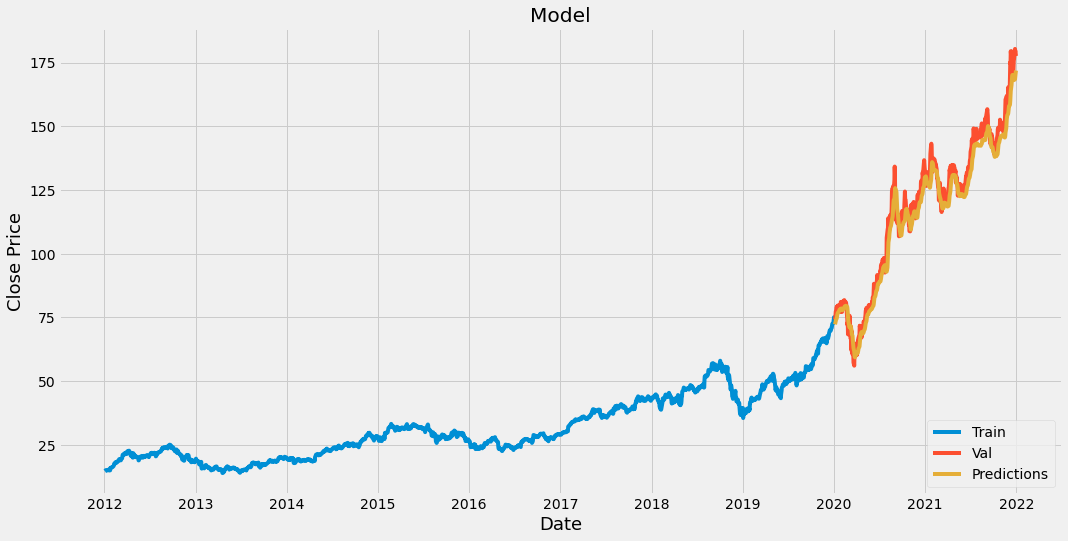

In [47]:
#visualize closing data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc = 'lower right')
plt.show()